In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.nn import Sequential, ReLU, Linear, Conv1d, LSTM, RNN, Dropout
from torch.nn import Module
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor   
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from scipy.stats import norm
from NCP.model import DeepSVD
from NCP.layers import SingularLayer, MLPOperator
from NCP.cdf import get_cdf, smooth_cdf
from NCP.metrics import hellinger, kullback_leibler, wasserstein1

from NCP.examples.tools.plot_utils import setup_plots, plot_expectation
from NCP.examples.tools.data_gen import gen_switching
setup_plots()

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Large region

### 1. split in the middle

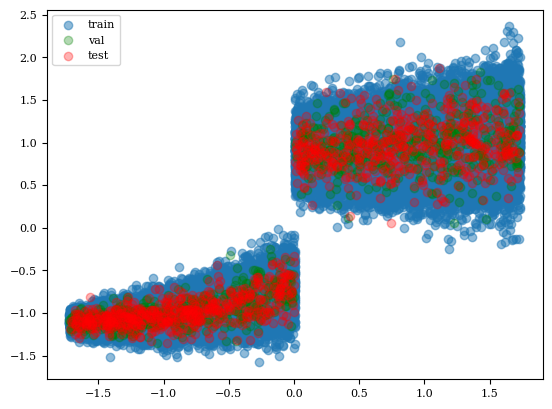

In [5]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_switching(0.5, 30, N_train=Ntrain, N_val=Nval, N_test=Ntest)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

epoch = 9999, loss = -1.5574326515197754: 100%|██████████| 10000/10000 [05:06<00:00, 32.68it/s]


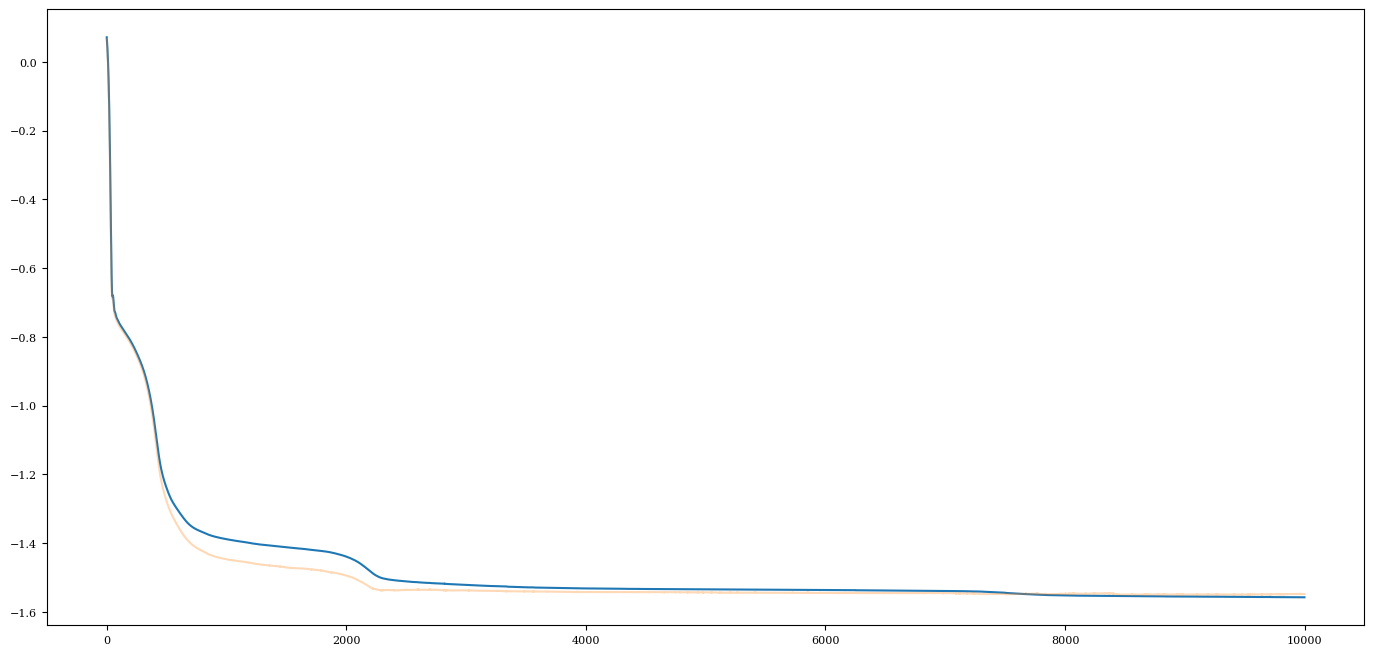

In [6]:
np.random.seed(0)
torch.manual_seed(0)

input_shape = X_train.shape[-1]
output_shape = 10
n_hidden = 2
layer_size = [16,16] # layer size of hidden layers.

U_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)
V_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': 1e-3
    }
reg = (DeepSVD(U_operator, V_operator, output_shape, gamma=0.01))

reg.fit(X_train, Y_train, X_val, Y_val, epochs=int(1e4), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

ls = reg.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(reg.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

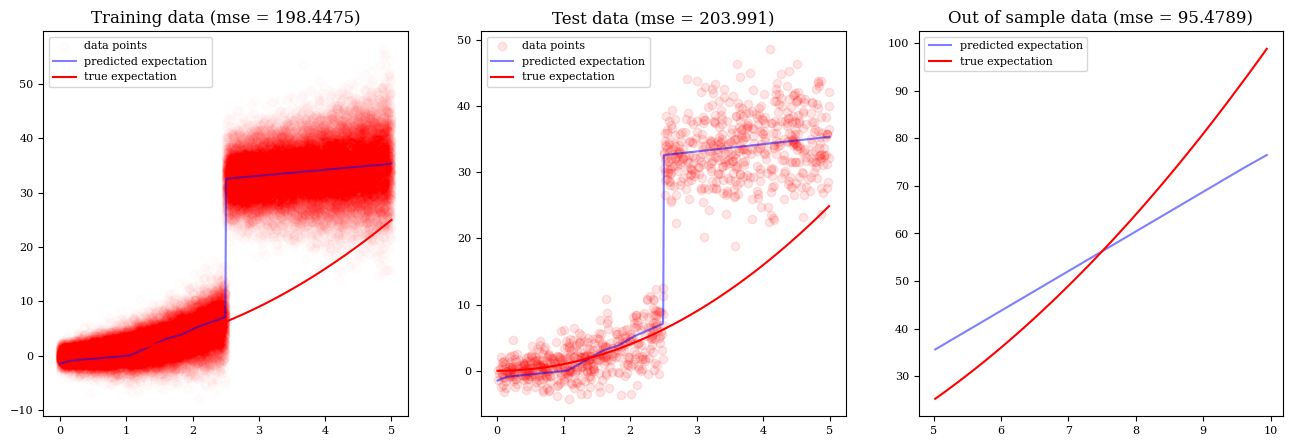

In [7]:
plot_expectation(reg, X_train, X_test, Y_train, Y_test, xscaler, yscaler)

result for x= 0
- KL: 0.5819892302521155
- Hellinger: 0.23184126729083862
result for x= 1
- KL: 0.5872879619878802
- Hellinger: 0.2306720418018389
result for x= 3
- KL: 0.5543655832314731
- Hellinger: 0.2251094026781325
result for x= 5
- KL: 0.6164634828175264
- Hellinger: 0.23466724313947346


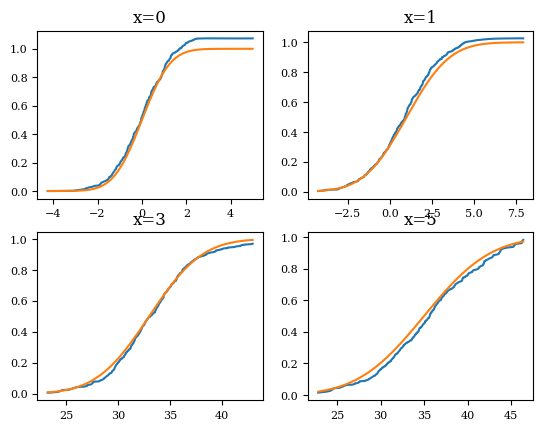

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(reg, x_scaled, postprocess='whitening', Y=Y_val)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    # normalising the plots for readability:
    if xi< 2.5:
        loc = xi**2
        scale = 1+np.abs(xi)
        true_cdf = norm.cdf(fys, loc=loc, scale=scale)
        plt_interv = [loc - 5*np.sqrt(scale), loc+5*np.sqrt(scale)]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    else:
        loc = xi + 30
        scale = 1+np.abs(xi)
        true_cdf = norm.cdf(fys, loc=loc, scale=scale)
        plt_interv = [loc - 5*np.sqrt(scale), loc+5*np.sqrt(scale)]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]      

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={round(xi, 3)}')
    print('result for x=', round(xi, 3))
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf, fys)}')
    #print(f'- Wasserstein: {wasserstein1(cdf_pred, true_cdf)}')

### 2. middle window

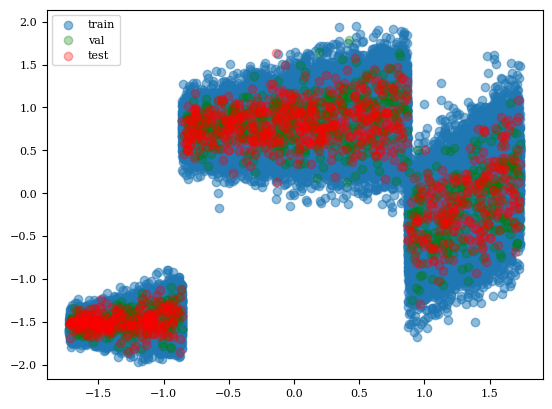

In [9]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_switching(0.5, 30, x_switch_min=1.25)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

epoch = 9999, loss = -2.0853488445281982: 100%|██████████| 10000/10000 [05:05<00:00, 32.69it/s]


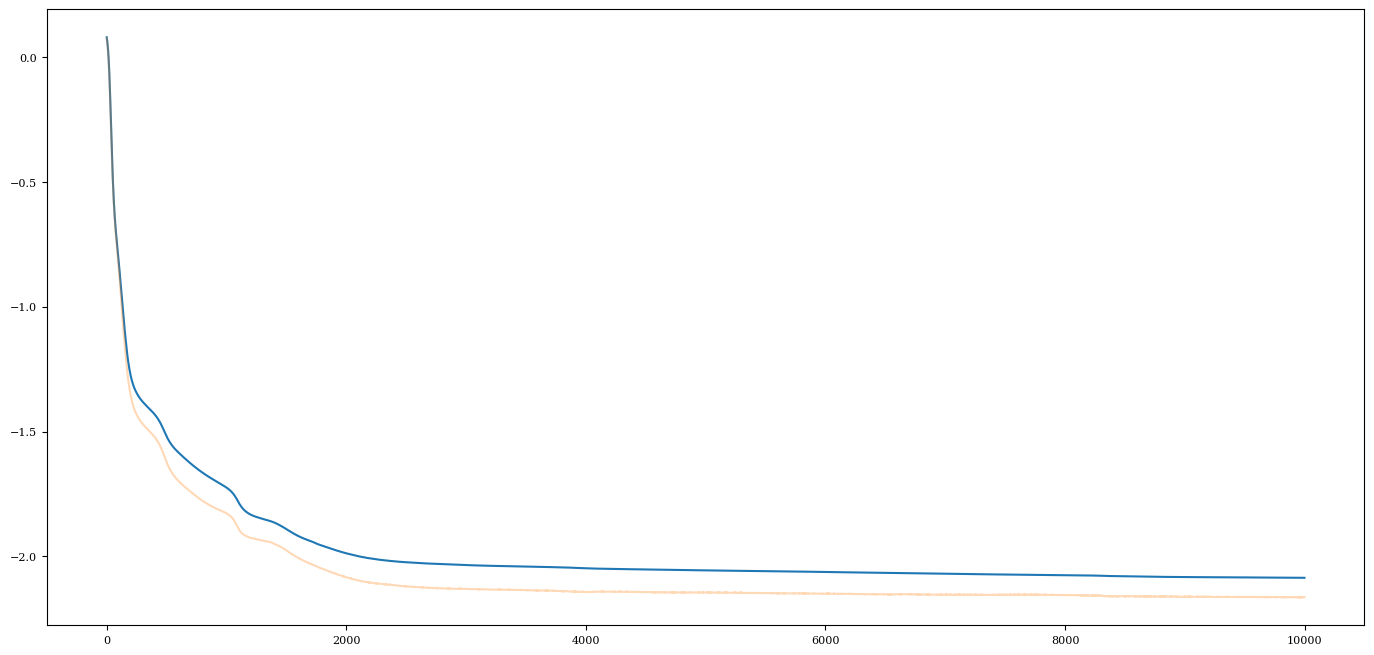

In [10]:
np.random.seed(0)
torch.manual_seed(0)

input_shape = X_train.shape[-1]
output_shape = 10
n_hidden = 2
layer_size = [16,16] # layer size of hidden layers.

U_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)
V_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': 1e-3
    }
reg = (DeepSVD(U_operator, V_operator, output_shape, gamma=0.01))

reg.fit(X_train, Y_train, X_val, Y_val, epochs=int(1e4), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

ls = reg.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(reg.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

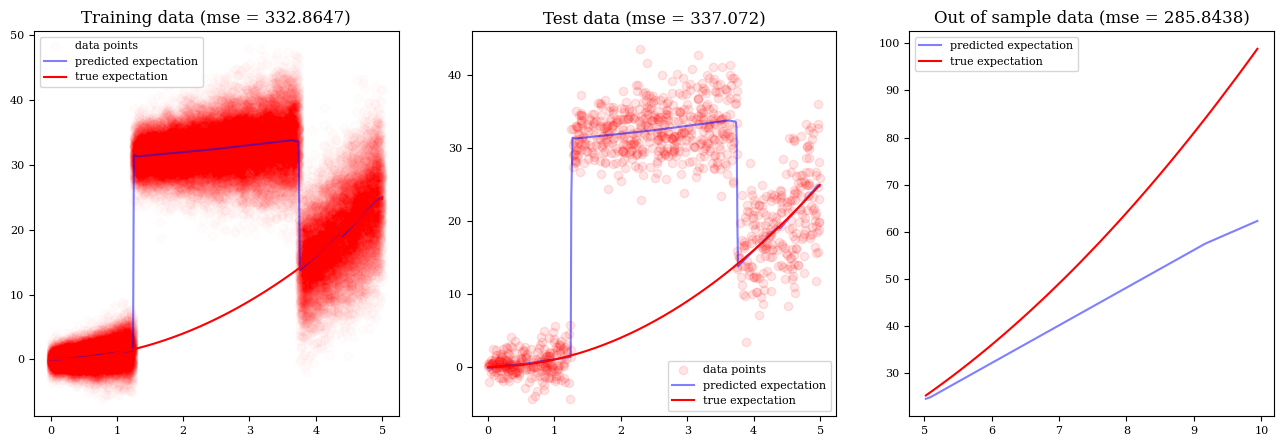

In [11]:
plot_expectation(reg, X_train, X_test, Y_train, Y_test, xscaler, yscaler)

result for x= 0
- KL: 0.5322681697641924
- Hellinger: 0.227444985429694
result for x= 1
- KL: 0.5151322591376264
- Hellinger: 0.21295555709466196
result for x= 3
- KL: 0.5140197827922752
- Hellinger: 0.20910531096341275
result for x= 4.5
- KL: 0.5505817749848443
- Hellinger: 0.2231733269514159


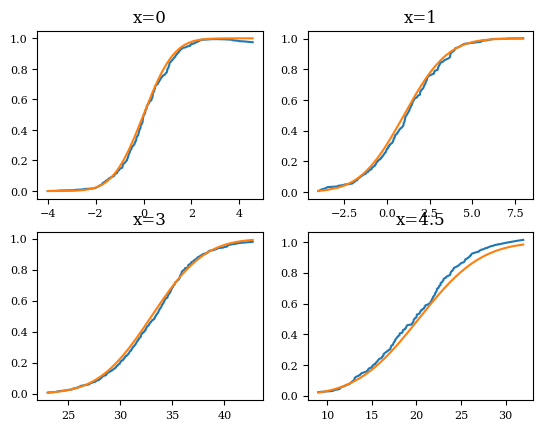

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 4.5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(reg, x_scaled, postprocess='whitening', Y=Y_val)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    # normalising the plots for readability:
    if xi< 1.25 or xi>3.75 :
        loc = xi**2
        scale = 1+np.abs(xi)
        true_cdf = norm.cdf(fys, loc=loc, scale=scale)
        plt_interv = [loc - 5*np.sqrt(scale), loc+5*np.sqrt(scale)]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    else:
        loc = xi + 30
        scale = 1+np.abs(xi)
        true_cdf = norm.cdf(fys, loc=loc, scale=scale)
        plt_interv = [loc - 5*np.sqrt(scale), loc+5*np.sqrt(scale)]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]   

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={round(xi, 3)}')
    print('result for x=', round(xi, 3))
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf, fys)}')
    #print(f'- Wasserstein: {wasserstein1(cdf_pred, true_cdf)}')

# Small region

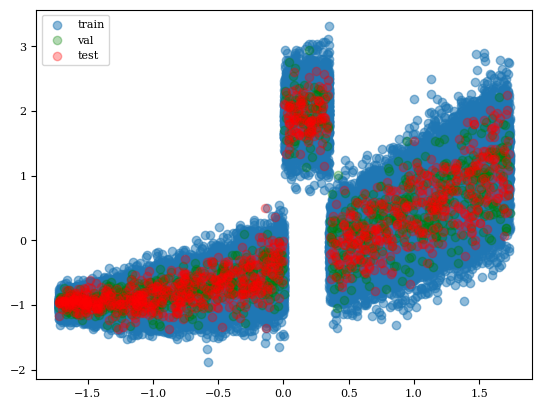

In [14]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_switching(0.1, 30)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

epoch = 9999, loss = -2.1891446113586426: 100%|██████████| 10000/10000 [05:50<00:00, 28.49it/s]


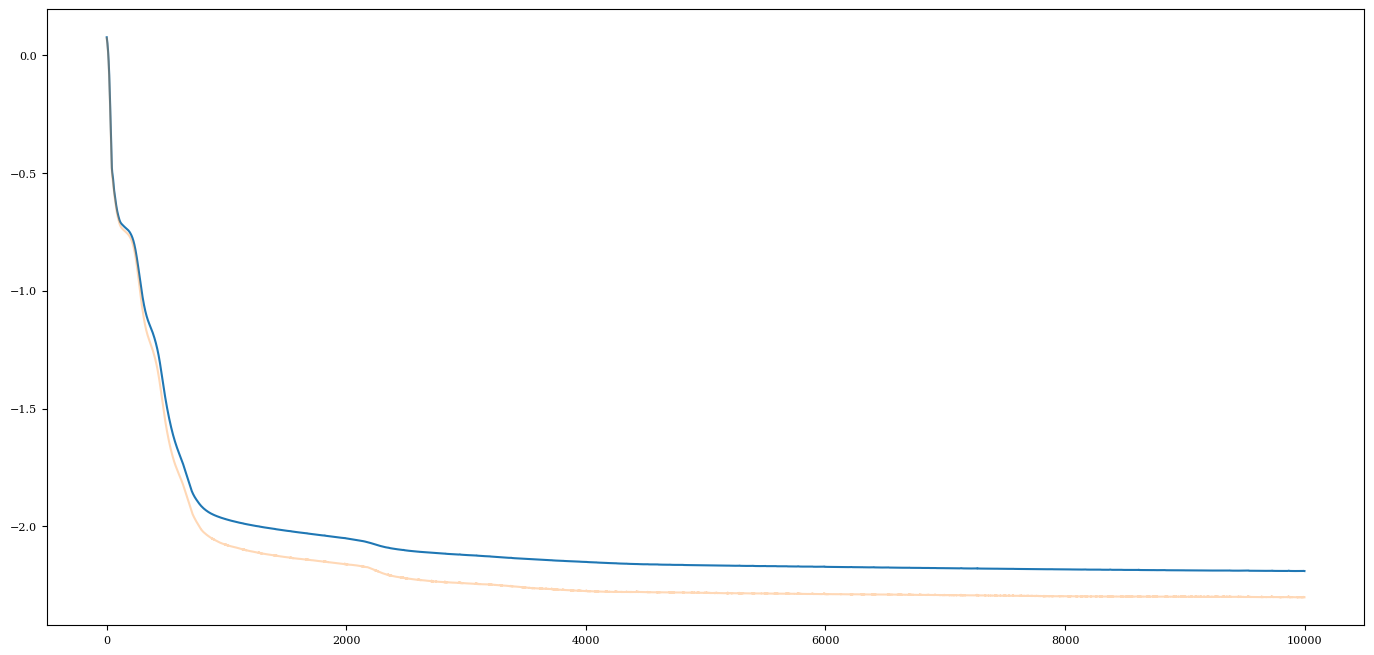

In [15]:
np.random.seed(0)
torch.manual_seed(0)

input_shape = X_train.shape[-1]
output_shape = 10
n_hidden = 2
layer_size = [16,16] # layer size of hidden layers.

U_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)
V_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': 1e-3
    }
reg = (DeepSVD(U_operator, V_operator, output_shape, gamma=0.01))

reg.fit(X_train, Y_train, X_val, Y_val, epochs=int(1e4), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

ls = reg.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(reg.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

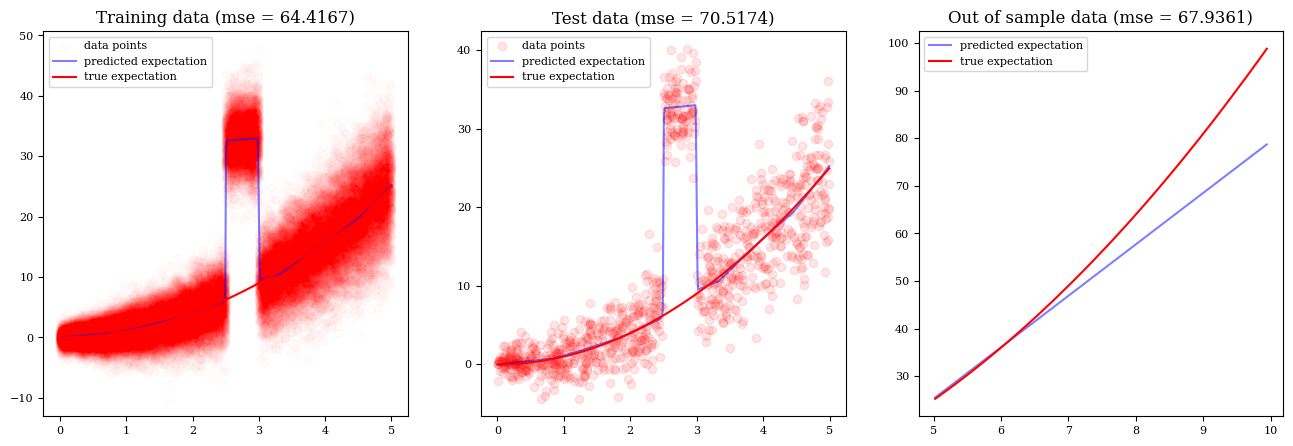

In [16]:
plot_expectation(reg, X_train, X_test, Y_train, Y_test, xscaler, yscaler)

result for x= 0
- KL: 0.6287383562762272
- Hellinger: 0.2650755493858871
result for x= 1
- KL: 0.6108619413163434
- Hellinger: 0.24924126887345777
result for x= 3.25
- KL: 0.6900346762187937
- Hellinger: 0.2670860941070302
result for x= 5
- KL: 0.6424380355463001
- Hellinger: 0.24204012883921014


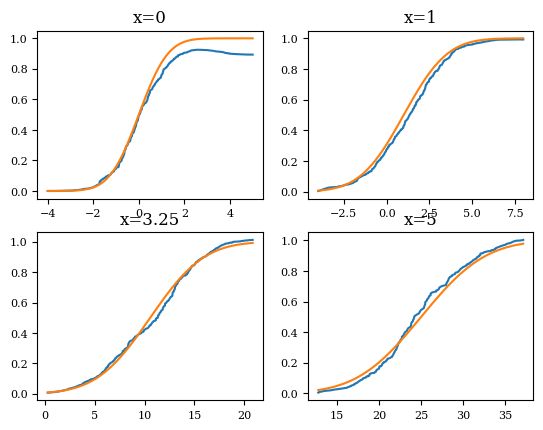

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3.25, 5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(reg, x_scaled, postprocess='whitening', Y=Y_val)
    cdf_pred_smooth = smooth_cdf(fys, cdf_pred)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    # normalising the plots for readability:
    if xi< 3 or xi >= 3.25:
        loc = xi**2
        scale = 1+np.abs(xi)
        true_cdf = norm.cdf(fys, loc=loc, scale=scale)
        plt_interv = [loc - 5*np.sqrt(scale), loc+5*np.sqrt(scale)]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]
        cdf_pred_smooth = cdf_pred_smooth[good_fys]

    else:
        loc = xi + 30
        scale = 1+np.abs(xi)
        true_cdf = norm.cdf(fys, loc=loc, scale=scale)
        plt_interv = [loc - 5*np.sqrt(scale), loc+5*np.sqrt(scale)]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]
        cdf_pred_smooth = cdf_pred_smooth[good_fys]        

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={round(xi, 3)}')
    print('result for x=', round(xi, 3))
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf, fys)}')
    #print(f'- Wasserstein: {wasserstein1(cdf_pred, true_cdf)}')